In [23]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADCLOUD_MODEL_STATE_DICT_PATH=os.getenv("RADCLOUD_MODEL_STATE_DICT_PATH")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")


sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.hermes_encoder import HermesEncoder
from mmwave_model_integrator.ground_truth_encoders.hermes_gt_encoder import HermesGTEncoder
# from mmwave_model_integrator.ground_truth_encoders.radsar_gt_encoder import RadSarGTEncoder
from mmwave_model_integrator.plotting.plotter_hermes import PlotterHermes
from mmwave_model_integrator.dataset_generators.hermes_dataset_generator import HermesDatasetGenerator

In [24]:
#setup the config manager
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_10Hz_lr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [25]:
#determine the paths to all of the datasets
#determine the paths to all of the datasets
train_datasets = [
    "hermes_cpsl_4",
    "hermes_cpsl_5",
    "hermes_cpsl_6"
]
train_scenario_folders = [os.path.join(MODEL_TRAINING_DATASET_PATH,"Hermes",dataset) for dataset in train_datasets]

test_datasets = [
    "hermes_north_vicon_1",
    "hermes_north_vicon_2",
    "hermes_north_vicon_3",
    "hermes_north_vicon_4",
    "hermes_north_vicon_5",
    "hermes_north_vicon_6"
]
test_scenario_folders = [os.path.join(MODEL_TRAINING_DATASET_PATH,"Hermes",dataset) for dataset in test_datasets]

In [26]:
#initializing the dataset generator
dataset_path = train_scenario_folders[0]
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="front_radar_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full",
    vehicle_odom_folder="vehicle_odom"
)

found 596 radar samples
found 595 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 595 vehicle velocity samples
found 595 vehicle odometry samples


In [27]:
#initialize the encoder and decoder
input_encoder = HermesEncoder(
    config_manager=cfg_manager,
    az_angle_bins_rad=np.deg2rad(np.linspace(
        start=-90,stop=90,num=90
    )),
    num_frames=5,
    stride=1,
    min_vel=np.array([0.00,0.30,0.0]),
    max_vel=np.array([0.1,0.70,0.1]), #np.array([0.05,0.50,0.05]),
    max_vel_stdev=np.array([0.02,0.02,0.02]), #np.array([0.02,0.02,0.02]),
    power_threshold_dB=20
)

ground_truth_encoder = HermesGTEncoder(
    hermes_encoder=input_encoder,
    candidate_points_threshold=0.05,
    valid_points_distance_threshold_m=1.0
)

plotter = PlotterHermes()

In [28]:
#go until the encoder is ready
idx = 0
while not input_encoder.full_encoding_ready:

    try: #try accessing the full odometry data
        vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
    except AssertionError: #if not just get the x velocity (forward)
        vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
        vel_data = np.array([vel,0,0])
    
    adc_cube = dataset.get_radar_data(idx)
    
    resp = input_encoder.encode(
        adc_data_cube=adc_cube,
        vels=vel_data
    )
    idx += 1

print(idx)

314


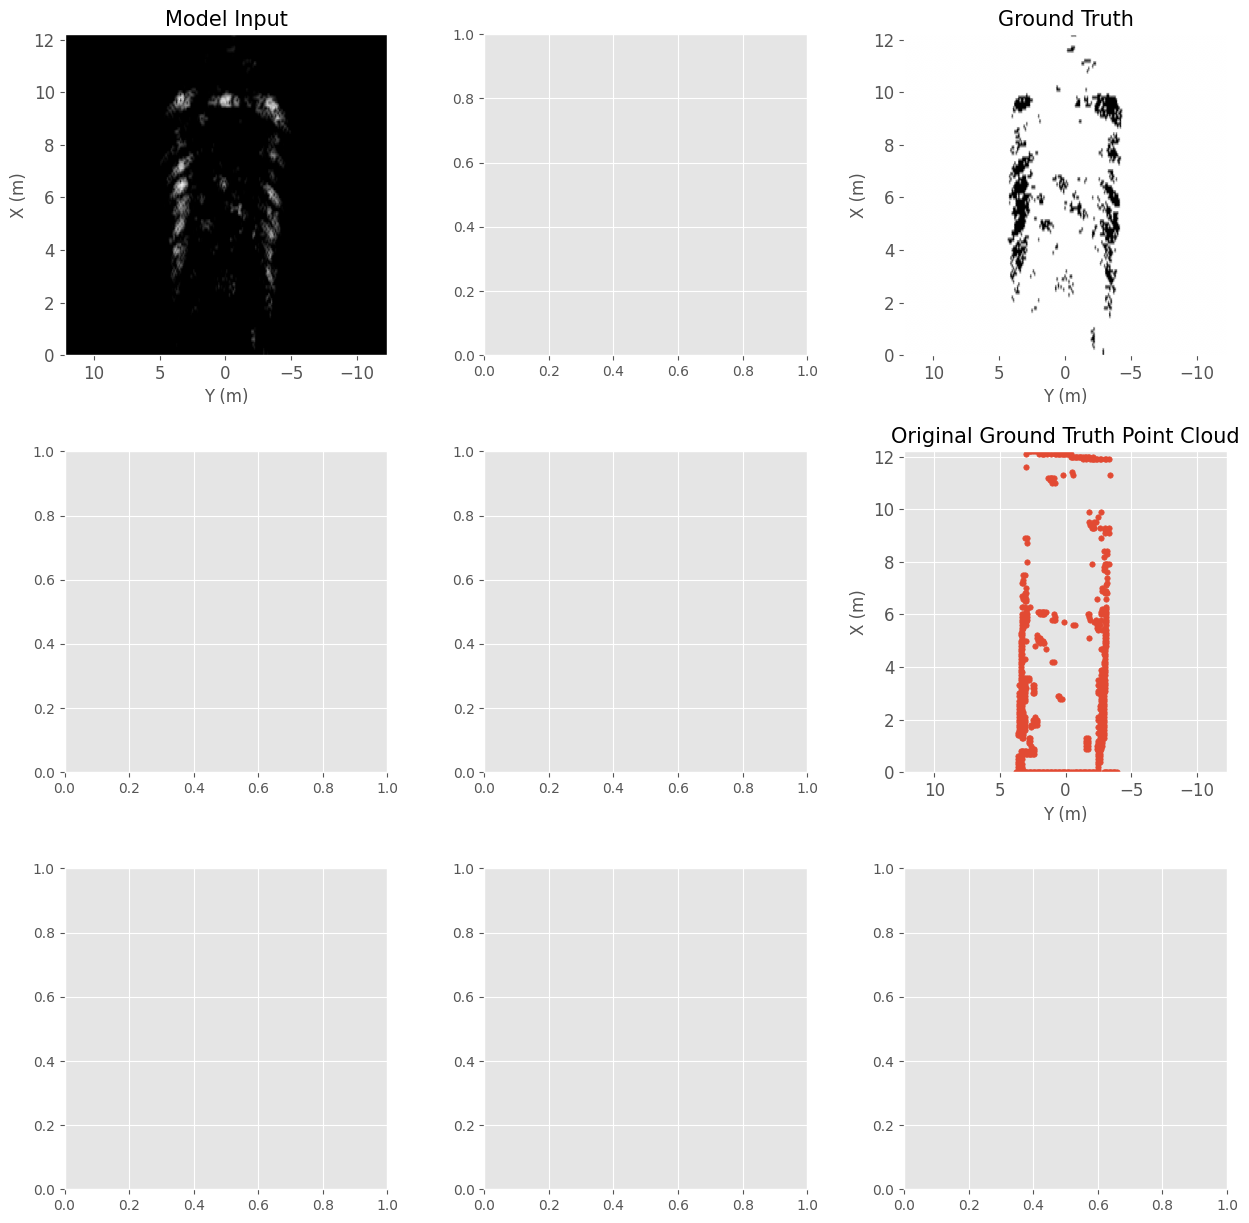

(123, 246)
(123, 246)


In [29]:
#prime the input encoder for data
sample_idx = idx - 1
for i in range(sample_idx):
    #get vel_data
    vel_data = np.mean(dataset.get_vehicle_odom_data(i)[:,8:11],axis=0)
    #convert into ned
    ned_vel_data = np.array([
        vel_data[0],
        vel_data[1],
        vel_data[2]
    ])

    #get adc data
    adc_cube = dataset.get_radar_data(i)

    #process the data
    input_encoder.encode(adc_cube,ned_vel_data)

adc_cube = dataset.get_radar_data(sample_idx)
# print(input_encoder.full_encoding_ready)

try: #try accessing the full odometry data
    vel_data = np.mean(dataset.get_vehicle_odom_data(sample_idx)[:,8:11],axis=0)
except AssertionError: #if not just get the x velocity (forward)
    vel = np.mean(dataset.get_vehicle_vel_data(sample_idx)[:,1])
    vel_data = np.array([vel,0,0])

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx)

plotter.plot_compilation(
    input_adc_cube=adc_cube,
    input_vels=vel_data,
    input_encoder=input_encoder,
    gt_data=lidar_pc,
    ground_truth_encoder=ground_truth_encoder,
    axs=[],
    show=True
)
print(input_encoder.encoded_data.shape)
print(ground_truth_encoder.gt_encoding.shape)

In [30]:
#initialize the dataset generator
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"Hermes_train")
dataset_generator = HermesDatasetGenerator(
    generated_dataset_path=generated_dataset_path,
    dataset_handler=dataset,
    input_encoder=input_encoder,
    ground_truth_encoder=ground_truth_encoder,
    generated_file_name="frame",
    input_encoding_folder="x_s",
    ground_truth_encoding_folder="y_s",
    clear_existing_data=True
)

DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/Hermes_train
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/Hermes_train
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/Hermes_train/x_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/Hermes_train/x_s
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/Hermes_train/y_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/Hermes_train/y_s


In [31]:
#generate the training dataset
dataset_generator.generate_dataset_from_multiple_scenarios(train_scenario_folders)

Generating data from scenario 0 of 3
found 596 radar samples
found 595 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 595 vehicle velocity samples
found 595 vehicle odometry samples


100%|██████████| 281/281 [00:01<00:00, 188.22it/s]


generated dataset now has 17 samples
Generating data from scenario 1 of 3
found 591 radar samples
found 591 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 591 vehicle velocity samples
found 591 vehicle odometry samples


100%|██████████| 376/376 [00:08<00:00, 46.68it/s]


generated dataset now has 112 samples
Generating data from scenario 2 of 3
found 734 radar samples
found 733 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 733 vehicle velocity samples
found 733 vehicle odometry samples


100%|██████████| 563/563 [00:08<00:00, 63.84it/s] 

generated dataset now has 213 samples


In [32]:
#generating the testing dataset
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"Hermes_test")
dataset_generator.reset(generated_dataset_path)
dataset_generator.generate_dataset_from_multiple_scenarios(test_scenario_folders)


DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/Hermes_test
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/Hermes_test
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/Hermes_test/x_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/Hermes_test/x_s
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/Hermes_test/y_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/Hermes_test/y_s
Generating data from scenario 0 of 6
found 1065 radar samples
found 1065 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 1065 vehicle velocity samples
found 1065 vehicle odometry samples


100%|██████████| 871/871 [00:12<00:00, 68.53it/s] 


generated dataset now has 158 samples
Generating data from scenario 1 of 6
found 916 radar samples
found 915 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 915 vehicle velocity samples
found 915 vehicle odometry samples


100%|██████████| 762/762 [00:04<00:00, 160.95it/s]


generated dataset now has 217 samples
Generating data from scenario 2 of 6
found 849 radar samples
found 848 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 848 vehicle velocity samples
found 848 vehicle odometry samples


100%|██████████| 663/663 [00:10<00:00, 60.99it/s] 


generated dataset now has 351 samples
Generating data from scenario 3 of 6
found 822 radar samples
found 822 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 821 vehicle velocity samples
found 821 vehicle odometry samples


100%|██████████| 625/625 [00:10<00:00, 58.48it/s] 


generated dataset now has 485 samples
Generating data from scenario 4 of 6
found 751 radar samples
found 751 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 751 vehicle velocity samples
found 751 vehicle odometry samples


100%|██████████| 566/566 [00:10<00:00, 55.47it/s] 


generated dataset now has 612 samples
Generating data from scenario 5 of 6
found 651 radar samples
found 651 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 651 vehicle velocity samples
found 651 vehicle odometry samples


100%|██████████| 462/462 [00:09<00:00, 50.06it/s]

generated dataset now has 730 samples


In [33]:
from mmwave_model_integrator.config import Config
config_path = "../configs/hermes_mini.py"
config = Config(config_path)

config.print_config()

model=dict(
    type=RadCloudUnet,
    encoder_input_channels=1,
    encoder_out_channels=(64, 128),
    decoder_input_channels=(256, 128),
    decoder_out_channels=64,
    output_channels=1,
    retain_dimmension=False,
    input_dimmensions=(64, 128),
),
generated_dataset=dict(
    input_encoding_folder=x_s,
    ground_truth_encoding_folder=y_s,
    generated_dataset_path=/home/david/Downloads/generated_datasets/Hermes_train,
),
trainer=dict(
    type=_BaseTorchTrainer,
    model=dict(
        type=RadCloudUnet,
        encoder_input_channels=1,
        encoder_out_channels=(64, 128),
        decoder_input_channels=(256, 128),
        decoder_out_channels=64,
        output_channels=1,
        retain_dimmension=False,
        input_dimmensions=(64, 128),
    ),
    optimizer=dict(
        type=Adam,
        lr=0.001,
    ),
    dataset=dict(
        type=_BaseTorchDataset,
        input_transforms=[{'type': 'ToTensor'}, {'type': 'Resize', 'size': (64, 128)}],
        output_transform

In [34]:
import mmwave_model_integrator.torch_training.trainers as trainers

trainer_config = config.trainer
trainer_class = getattr(trainers,trainer_config.pop('type'))
trainer = trainer_class(**trainer_config)

ModelTrainer: 181 train, 32 val samples loaded
_BaseTorchTrainer._check_for_directory: found directory working_dir


In [35]:
#train the model
trainer.train_model()

ModelTrainer.train: training the network...


  4%|▍         | 1/25 [00:01<00:41,  1.72s/it]

EPOCH: 1/25
	 Train loss: 0.4573019742965698, Val loss:0.324883371591568


  8%|▊         | 2/25 [00:03<00:38,  1.67s/it]

EPOCH: 2/25
	 Train loss: 0.28331270813941956, Val loss:0.23785841464996338


 12%|█▏        | 3/25 [00:04<00:36,  1.66s/it]

EPOCH: 3/25
	 Train loss: 0.2231874316930771, Val loss:0.19874213635921478


 16%|█▌        | 4/25 [00:06<00:34,  1.65s/it]

EPOCH: 4/25
	 Train loss: 0.1914428174495697, Val loss:0.17824102938175201


 20%|██        | 5/25 [00:08<00:33,  1.65s/it]

EPOCH: 5/25
	 Train loss: 0.1706809103488922, Val loss:0.15569964051246643


 24%|██▍       | 6/25 [00:09<00:31,  1.66s/it]

EPOCH: 6/25
	 Train loss: 0.15864360332489014, Val loss:0.1534753143787384


 28%|██▊       | 7/25 [00:11<00:29,  1.65s/it]

EPOCH: 7/25
	 Train loss: 0.15115317702293396, Val loss:0.1515805423259735


 32%|███▏      | 8/25 [00:13<00:28,  1.65s/it]

EPOCH: 8/25
	 Train loss: 0.14448581635951996, Val loss:0.1393660008907318


 36%|███▌      | 9/25 [00:14<00:26,  1.66s/it]

EPOCH: 9/25
	 Train loss: 0.1434771567583084, Val loss:0.14962759613990784


 40%|████      | 10/25 [00:16<00:24,  1.66s/it]

EPOCH: 10/25
	 Train loss: 0.13890142738819122, Val loss:0.1347428858280182


 44%|████▍     | 11/25 [00:18<00:23,  1.66s/it]

EPOCH: 11/25
	 Train loss: 0.13509197533130646, Val loss:0.12860698997974396


 48%|████▊     | 12/25 [00:19<00:21,  1.66s/it]

EPOCH: 12/25
	 Train loss: 0.1335553526878357, Val loss:0.1268145740032196


 52%|█████▏    | 13/25 [00:21<00:19,  1.66s/it]

EPOCH: 13/25
	 Train loss: 0.13100028038024902, Val loss:0.1281147599220276


 56%|█████▌    | 14/25 [00:23<00:18,  1.66s/it]

EPOCH: 14/25
	 Train loss: 0.13065105676651, Val loss:0.1535167098045349


 60%|██████    | 15/25 [00:24<00:16,  1.66s/it]

EPOCH: 15/25
	 Train loss: 0.12699700891971588, Val loss:0.150808647274971


 64%|██████▍   | 16/25 [00:26<00:14,  1.66s/it]

EPOCH: 16/25
	 Train loss: 0.1265449821949005, Val loss:0.12633275985717773


 68%|██████▊   | 17/25 [00:28<00:13,  1.66s/it]

EPOCH: 17/25
	 Train loss: 0.1266588717699051, Val loss:0.12355361133813858


 72%|███████▏  | 18/25 [00:29<00:11,  1.66s/it]

EPOCH: 18/25
	 Train loss: 0.12607012689113617, Val loss:0.1251491904258728


 76%|███████▌  | 19/25 [00:31<00:09,  1.66s/it]

EPOCH: 19/25
	 Train loss: 0.12544456124305725, Val loss:0.12306428700685501


 80%|████████  | 20/25 [00:33<00:08,  1.67s/it]

EPOCH: 20/25
	 Train loss: 0.12515416741371155, Val loss:0.12112678587436676


 84%|████████▍ | 21/25 [00:34<00:06,  1.67s/it]

EPOCH: 21/25
	 Train loss: 0.12382284551858902, Val loss:0.12056204676628113


 88%|████████▊ | 22/25 [00:36<00:05,  1.67s/it]

EPOCH: 22/25
	 Train loss: 0.12325636297464371, Val loss:0.14152660965919495


 92%|█████████▏| 23/25 [00:38<00:03,  1.68s/it]

EPOCH: 23/25
	 Train loss: 0.12481769919395447, Val loss:0.12048432976007462


 96%|█████████▌| 24/25 [00:39<00:01,  1.68s/it]

EPOCH: 24/25
	 Train loss: 0.12252513319253922, Val loss:0.12608030438423157


100%|██████████| 25/25 [00:41<00:00,  1.66s/it]

EPOCH: 25/25
	 Train loss: 0.12365885823965073, Val loss:0.11992049962282181
ModelTrainer.train: total training time 41.59
